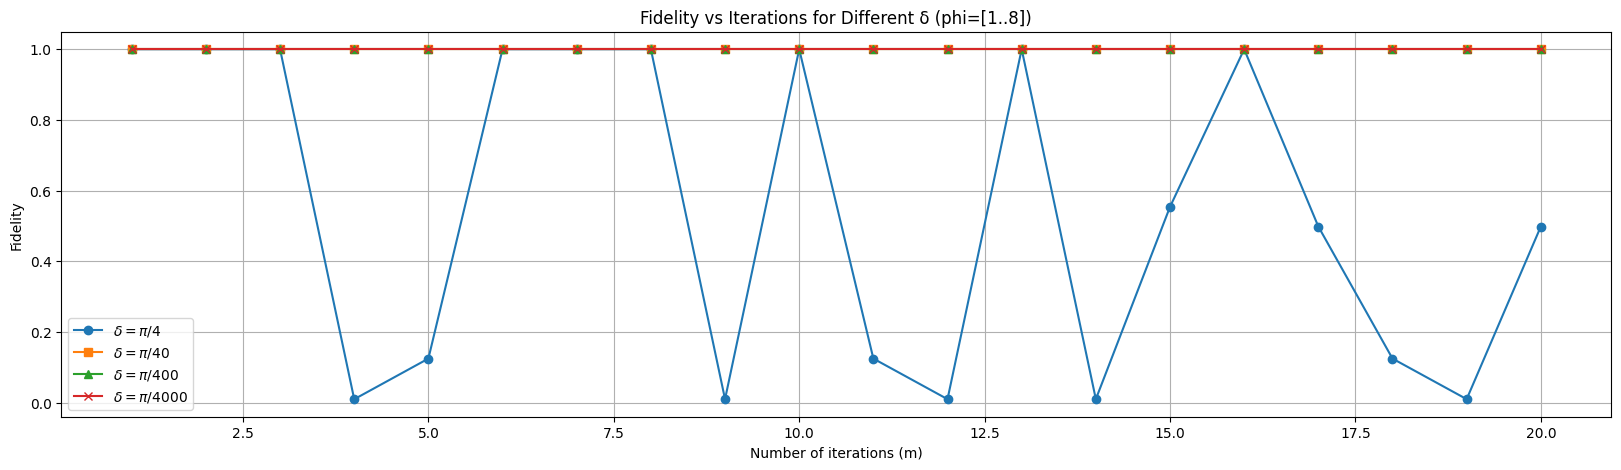

In [30]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# --- define psi and phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]        # initial psi vector
phi = [1, 1, 1, 1, 1, 1, 1, 1]        # phi for programmable phase

N = 8
n = 3                    # number of qubits (log2 of vector length)
number_of_layers = 2     # layers for MPS initialization

# --- create normalized QuantumState objects ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# --- generate MPS initializer circuits ---
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

# --- protocol function ---
def run_protocol(m, delta, return_state=False):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    # initialize states
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # iterative protocol
    for k in range(1, m+1):
        # CNOT flags
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # apply small phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ, measure, reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        if k < m:
            qc.append(U_phi, phi_reg)

    # simulate
    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # reduced density matrix for ψ
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # Ideal target vector with programmable phase
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # fidelity
    fid = state_fidelity(rho_psi, rho_ideal)

    if return_state:
        return fid, rho_psi, ideal_vec
    return fid

# --- run for multiple iterations ---
m_values = list(range(1, 21))

# fidelity for different deltas
delta_values = [np.pi/4, np.pi/40, np.pi/400, np.pi/4000]
fidelities_list = []

for delta_val in delta_values:
    fidelities = [run_protocol(m, delta_val) for m in m_values]
    fidelities_list.append(fidelities)

# --- plot fidelity results ---
plt.figure(figsize=(20,5))
labels = [r'$\delta = \pi/4$', r'$\delta = \pi/40$', r'$\delta = \pi/400$', r'$\delta = \pi/4000$']
markers = ['o-', 's-', '^-', 'x-']
for fids, lbl, mk in zip(fidelities_list, labels, markers):
    plt.plot(m_values, fids, mk, label=lbl)
plt.xlabel("Number of iterations (m)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Iterations for Different δ (phi=[1..8])")
plt.legend()
plt.grid(True)
plt.show()



Example m=20, δ=0.07854: Fidelity=1.000000


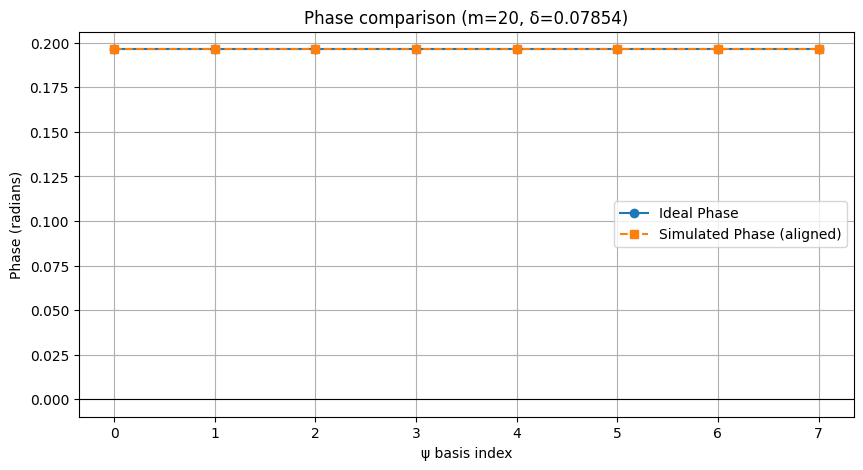

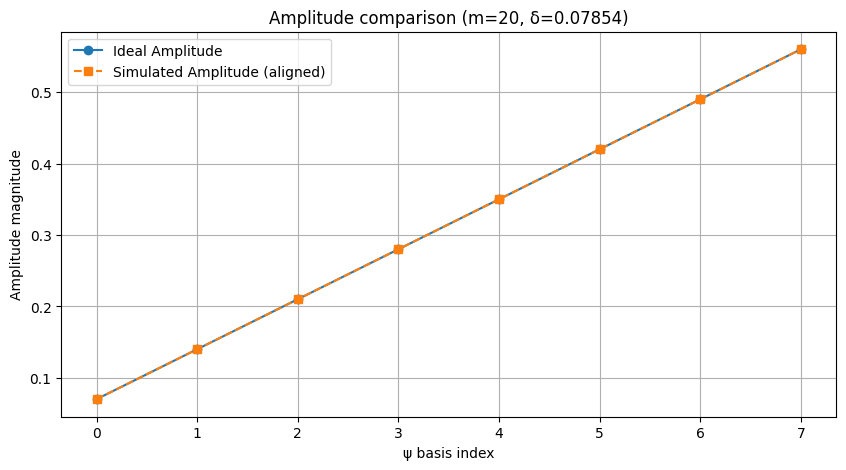

In [31]:

# ==============================================================

m_example = 20
delta_example = np.pi/40

fid_ex, rho_psi, ideal_vec = run_protocol(m_example, delta_example, return_state=True)
vec_sim = np.array(rho_psi.to_statevector())

# --- Align global phase ---
global_phase = np.angle(np.vdot(ideal_vec, vec_sim))
vec_sim_aligned = vec_sim * np.exp(-1j * global_phase)

# --- amplitudes and phases ---
amps_ideal = np.abs(ideal_vec)
amps_sim = np.abs(vec_sim_aligned)
phases_ideal = np.unwrap(np.angle(ideal_vec))
phases_sim = np.unwrap(np.angle(vec_sim_aligned))

print(f"Example m={m_example}, δ={delta_example:.5f}: Fidelity={fid_ex:.6f}")

# --- Phase comparison ---
plt.figure(figsize=(10,5))
plt.plot(range(N), phases_ideal, 'o-', label="Ideal Phase")
plt.plot(range(N), phases_sim, 's--', label="Simulated Phase (aligned)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Phase (radians)")
plt.xlabel("ψ basis index")
plt.title(f"Phase comparison (m={m_example}, δ={delta_example:.5f})")
plt.legend()
plt.grid(True)
plt.show()

# --- Amplitude comparison ---
plt.figure(figsize=(10,5))
plt.plot(range(N), amps_ideal, 'o-', label="Ideal Amplitude")
plt.plot(range(N), amps_sim, 's--', label="Simulated Amplitude (aligned)")
plt.ylabel("Amplitude magnitude")
plt.xlabel("ψ basis index")
plt.title(f"Amplitude comparison (m={m_example}, δ={delta_example:.5f})")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
import pandas as pd

# choose a short name for this phi type
phi_type = "eflat"   # change to "flat", "linear", "periodic", "random", etc.

# --- Save amplitude & phase data for this run ---
data = {
    "phi_type": phi_type,
    "alpha": 0.5,                 # include parameters if relevant
    "delta": delta_example,
    "m": m_example,
    "phi_values": [phi],
    "amps_ideal": [amps_ideal.tolist()],
    "amps_sim": [amps_sim.tolist()],
    "phases_ideal": [phases_ideal.tolist()],
    "phases_sim": [phases_sim.tolist()],
    "fidelity": [fid_ex]
}

df = pd.DataFrame(data)
df.to_csv(f"dataset_{phi_type}.csv", index=False)
print(f"✅ Saved {phi_type} dataset → dataset_{phi_type}.csv")


✅ Saved eflat dataset → dataset_eflat.csv


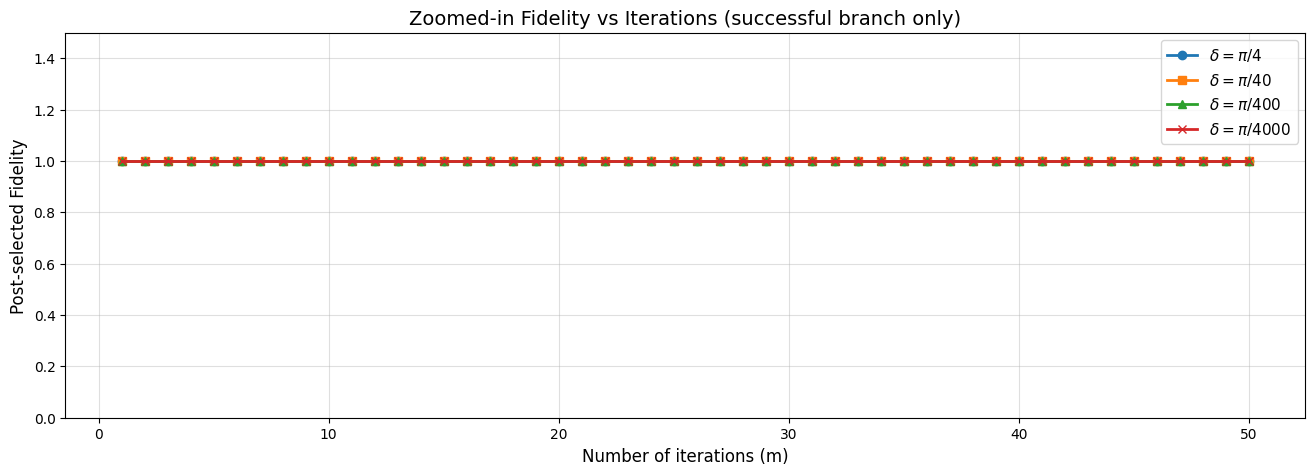

In [32]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# --- define psi and phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]        # initial psi vector
phi = [1, 1, 1, 1, 1, 1, 1, 1]        # phi for programmable phase (uniform)

N = 8
n = 3                    # number of qubits (log2 of vector length)
number_of_layers = 2     # layers for MPS initialization

# --- create normalized QuantumState objects ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# --- generate MPS initializer circuits ---
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

def init_round(delta):
    
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    qc = QuantumCircuit(psi_reg, phi_reg, name="round")

    # equality flags using your ctrl_state=0 trick
    for i in range(n):
        qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

    # small phase on the "all-equal" subspace
    qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

    # uncompute flags
    for i in range(n):
        qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

    # rotate ancilla back to computational basis of |0...0> success
    qc.append(U_phi_dagger, phi_reg)

    return qc

def project_ancilla_zero(statevec, n_psi, n_phi):
    """
    Post-select ancilla register (the *second* n-qubit block) onto |0...0>.
    Qiskit's ordering for appended registers puts ancilla bits as the
    MORE significant bits, so indices 0..(2^n_psi - 1) correspond to ancilla=0.
    """
    dim_psi = 2 ** n_psi
    dim_phi = 2 ** n_phi

    v = np.array(statevec.data, dtype=complex, copy=True)
    # keep only amplitudes where ancilla index == 0  (first block of length dim_psi)
    v[dim_psi:] = 0.0

    p_succ = float(np.real(np.vdot(v, v)))  # success probability
    if p_succ == 0.0:
        return None, 0.0  # no successful branch

    v /= np.sqrt(p_succ)
    return Statevector(v), p_succ

def run_protocol_success_only(m, delta, return_extra=False):
    """evolve the statevector, project ancilla to |0...0| after each round,
    renormalize, reprepare ancilla |phi>, and continue.
    """
    # Build an init circuit for |psi>⊗|phi>
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    init = QuantumCircuit(psi_reg, phi_reg)
    init.append(U_psi, psi_reg)
    init.append(U_phi, phi_reg)

    # Statevector start
    sv = Statevector.from_instruction(init)

    # Pre-build the unitary for a single round (faster to reuse)
    round_qc = init_round(delta)

    total_success_prob = 1.0
    for _ in range(m):
        # evolve by one round up to U_phi_dagger
        sv = sv.evolve(round_qc)

        # post-select ancilla all-zero outcome
        sv_proj, p = project_ancilla_zero(sv, n_psi=n, n_phi=n)
        if p == 0.0:
            # no successful branch: fidelity undefined for this (m, delta)
            if return_extra:
                return np.nan, {"success_prob": 0.0}
            return np.nan
        total_success_prob *= p
        sv = sv_proj

        # re-prepare ancilla back to |phi> for the next round
        sv = sv.evolve(U_phi, qargs=list(range(n, 2*n)))  # act on ancilla register

    # compute reduced density of ψ and target
    rho_full = DensityMatrix(sv)
    rho_psi = partial_trace(rho_full, list(range(n, 2*n)))

    psi_vec = np.array(psi, dtype=complex) / np.linalg.norm(psi)
    phi_vec = np.array(phi, dtype=complex) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    fid = state_fidelity(rho_psi, rho_ideal)

    if return_extra:
        return float(fid), {"success_prob": float(total_success_prob)}
    return float(fid)

# --- sweep m and δ, plot post-selected fidelity (success branch only) ---
m_values = list(range(1, 51))
delta_values = [np.pi/4, np.pi/40, np.pi/400, np.pi/4000]
labels = [r'$\delta = \pi/4$', r'$\delta = \pi/40$', r'$\delta = \pi/400$', r'$\delta = \pi/4000$']
markers = ['o-', 's-', '^-', 'x-']

fidelities_list = []
success_probs = []

for delta_val in delta_values:
    fids_for_delta = []
    probs_for_delta = []
    for m in m_values:
        fid, meta = run_protocol_success_only(m, delta_val, return_extra=True)
        fids_for_delta.append(fid)
        probs_for_delta.append(meta["success_prob"])
    fidelities_list.append(fids_for_delta)
    success_probs.append(probs_for_delta)

# --- zoomed-in fidelity plot for clear comparison ---
plt.figure(figsize=(16,5))
for fids, lbl, mk in zip(fidelities_list, labels, markers):
    plt.plot(m_values, fids, mk, label=lbl, linewidth=2, markersize=6)

# --- fixed y-axis range (no zoom) ---
plt.ylim(0, 1.5)



plt.xlabel("Number of iterations (m)", fontsize=12)
plt.ylabel("Post-selected Fidelity", fontsize=12)
plt.title("Zoomed-in Fidelity vs Iterations (successful branch only)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.4)
plt.show()





In [40]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# --- define psi and phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 1, 1, 1, 1, 1, 1, 1]

n = 3
number_of_layers = 2

# --- create normalized QuantumState objects ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# --- generate MPS initializer circuits ---
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()


# ============================================================
# 1) Build circuit for given (delta, m)
# ============================================================
def build_protocol(delta, m):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for _ in range(m):
        # CNOT flag steps
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # small phase
        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute phi, measure and reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        # reinitialize φ (except last iteration)
        qc.append(U_phi, phi_reg)

    return qc


# ============================================================
# 2) Run fidelity (statevector simulation)
# ============================================================
def run_fidelity(delta, m):
    qc = build_protocol(delta, m)
    sim = AerSimulator(method="statevector")
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # partial trace to get ψ subsystem
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # ideal state
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    return state_fidelity(rho_psi, rho_ideal), qc


# ============================================================
# 3) Run for given number of shots (measurement simulation)
# ============================================================
def run_shots(delta, m, shots=1024):
    qc = build_protocol(delta, m)
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)
    return counts, qc




δ = 0.00785, m = 1, shots = 1000
Successful shots (ancilla = 000): 1000/1000
Success rate = 1.000


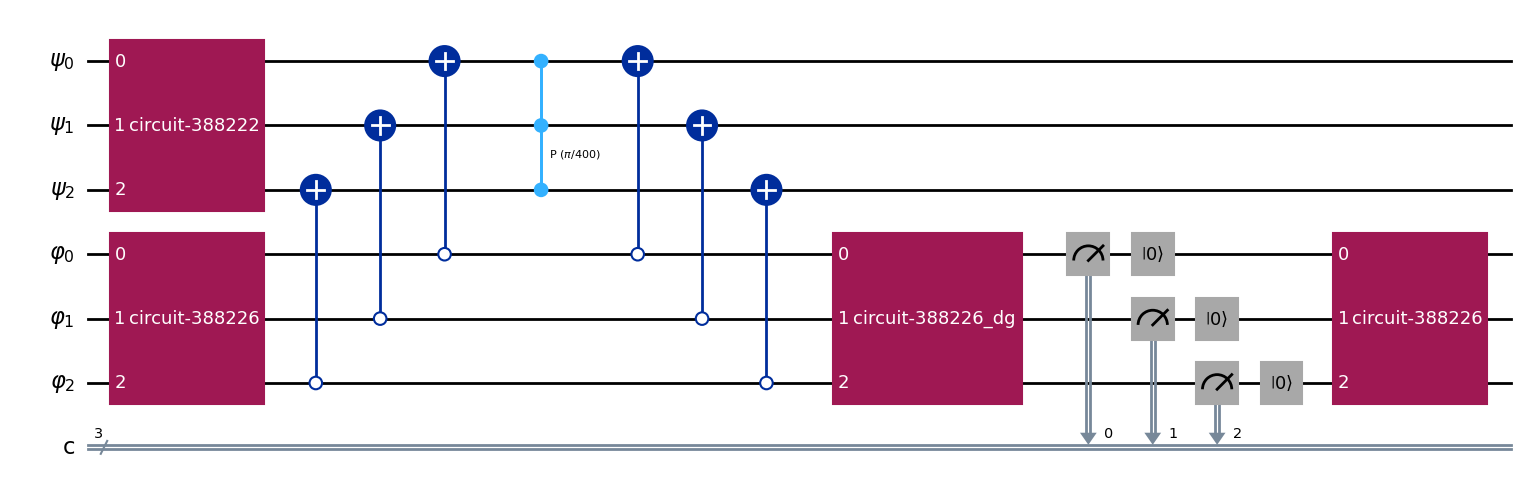

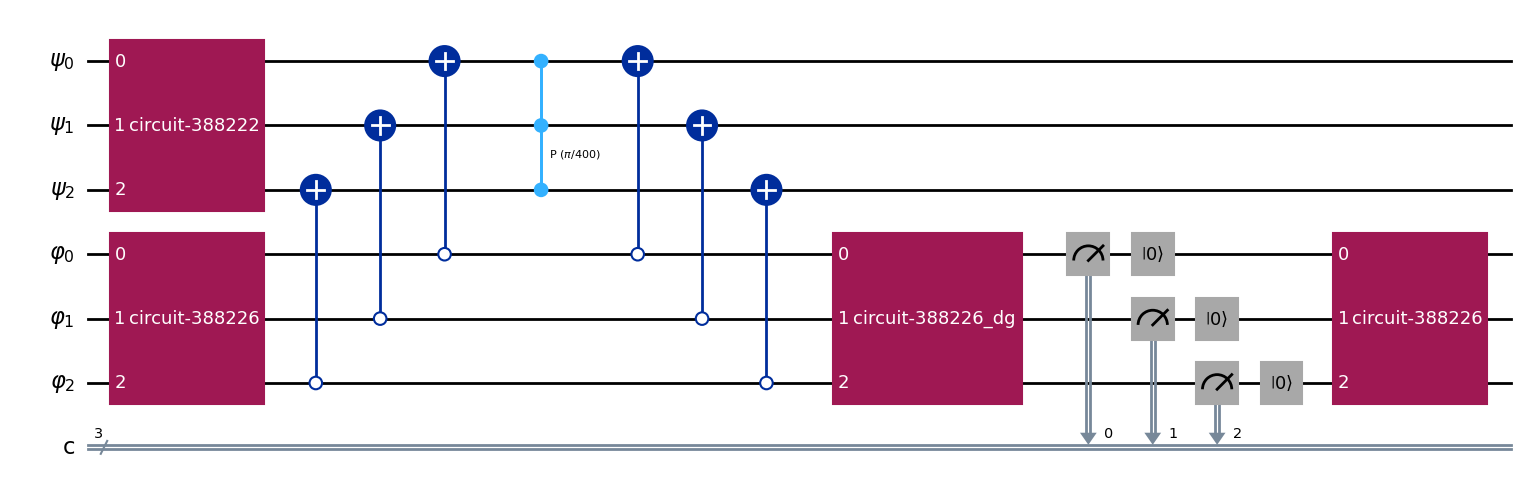

In [41]:
def success_rate(delta, m=1, shots=1000):
    qc = build_protocol(delta, m)
    sim = AerSimulator()
    tqc = transpile(qc, sim)

    # run with memory output for individual shots
    result = sim.run(tqc, shots=shots, memory=True).result()
    memories = result.get_memory(qc)     # list of measured bitstrings

    # count how many are all zeros
    zero_state = "0" * n
    successes = sum(1 for s in memories if s == zero_state)
    success_fraction = successes / shots

    print(f"δ = {delta:.5f}, m = {m}, shots = {shots}")
    print(f"Successful shots (ancilla = {zero_state}): {successes}/{shots}")
    print(f"Success rate = {success_fraction:.3f}")

    return success_fraction, memories, qc

# Example usage:
delta = np.pi/400
success_fraction, all_shots, qc = success_rate(delta, m=1, shots=1000)

# Show the circuit diagram
qc.draw("mpl")
